```
This notebook sets up and runs a set of benchmarks to compare
different numerical discretizations of the SWEs

Copyright (C) 2016  SINTEF ICT

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

#Import packages we need
import numpy as np
from matplotlib import animation, rc
from matplotlib import pyplot as plt

import pyopencl
import subprocess
import os
import StringIO
import gc

#Set large figure sizes
rc('figure', figsize=(16.0, 12.0))
rc('animation', html='html5')

#Finally, import our simulator
from SWESimulators import FBL, CTCS, LxF, FORCE, HLL, HLL2, KP07, KP07_dimsplit, WAF, CDKLM16, DataOutput, PlotHelper

In [2]:
#Make sure we get compiler output from OpenCL
os.environ["PYOPENCL_COMPILER_OUTPUT"] = "1"

#Set which CL device to use, and disable kernel caching
os.environ["PYOPENCL_CTX"] = "1"
os.environ["CUDA_CACHE_DISABLE"] = "1"
os.environ["PYOPENCL_COMPILER_OUTPUT"] = "1"
os.environ["PYOPENCL_NO_CACHE"] = "1"

#Create OpenCL context
cl_ctx = pyopencl.create_some_context()
print "Using ", cl_ctx.devices[0].name

Using  GeForce 840M


In [3]:
def setBwStyles(ax):
    from cycler import cycler

    ax.set_prop_cycle( cycler('marker', ['.', 'x', 4, '+', '*', '1', 5]) +
                       cycler('linestyle', ['-.', '--', ':', '-.', '--', ':', '-.']) +
                       #cycler('markersize', [5, 5, 5, 5, 5, 5]) +
                       cycler('color', ['k', 'k', 'k', 'k', 'k', 'k', 'k']) )

In [4]:
def gen_test_data(nx, num_ghost_cells):
    ny = 1
    width = 100.0
    dx = width / float(nx)
    dy = 1.0

    h = np.zeros((ny+2*num_ghost_cells, nx+2*num_ghost_cells), dtype=np.float32); 
    hu = np.zeros((ny+2*num_ghost_cells, nx+2*num_ghost_cells), dtype=np.float32);
    hv = np.zeros((ny+2*num_ghost_cells, nx+2*num_ghost_cells), dtype=np.float32);

    #Create a gaussian "dam break" that will not form shocks
    x_center = dx*nx/2.0
    size = width / 5.0
    for j in range(-num_ghost_cells, ny+num_ghost_cells):
        for i in range(-num_ghost_cells, nx+num_ghost_cells):
            x = dx*(i+0.5) - x_center
            
            h[j+num_ghost_cells, i+num_ghost_cells] = 0.5 + 0.1*np.exp(-(x**2/size))
            hu[j+num_ghost_cells, i+num_ghost_cells] = 0.1*np.exp(-(x**2/size))
    
    return h, hu, hv, dx, dy, nx, ny

In [5]:
def run_benchmark(simulator, nx, ghost_cells, g=9.81, courant_number=None, dt_in=None, nosave=False):    
    datafilename = "smooth1d_nx=" + str(simulator) + "_" + str(nx) + ".npz"

    #If we do not have the high-res data, generate it    
    if (nosave or not os.path.isfile(datafilename)):
        
        h0, hu0, hv0, dx, dy, nx, ny = gen_test_data(nx, ghost_cells)
        
        max_u = 1.0; #Estimate of maximum velocity for dt
        if (dt_in and courant_number):
            raise Exception("Both dt and courant number specified")
        elif (dt_in and not courant_number):
            dt = dt_in
        elif (courant_number and not dt_in):
            dt = courant_number * dx / (max_u + np.sqrt(g*0.6))
        else:
            courant_number = 0.9 / float(ghost_cells)
            dt = 0.5*courant_number * dx / (max_u + np.sqrt(g*0.6))
            

        #Initialize simulator
        sim = simulator(cl_ctx,
                        h0, hu0, hv0, \
                        nx, ny, \
                        dx, dy, dt, \
                        g)

        t = sim.step(2.0)
        h, hu, hv = sim.download()

        h = h[ghost_cells, ghost_cells:-ghost_cells]
        hu = hu[ghost_cells, ghost_cells:-ghost_cells]
        hv = hv[ghost_cells, ghost_cells:-ghost_cells]
        
        if (nosave):
            return h, None, None
        else:
            np.savez_compressed(datafilename, h=h, hu=hu, hv=hv)
        
        gc.collect() # Force run garbage collection to free up memory
        
        
    
    #Read the solution
    with np.load(datafilename) as data:
        h = data['h']
        #hu = data['hu']
        #hv = data['hv']
        hu = None
        hv = None
        
    gc.collect() # Force run garbage collection to free up memory
        
    return h, hu, hv

In [6]:
'''
def downsample(highres_solution, nx):
    #"Downsample" to requested number of points
    #Since our solution is a set of piecewise constant functions, we must integrate this function over our 
    #desired output mesh
    highres_nx = highres_solution.shape[0]
    scaling_factor = highres_nx / float(nx)
            
    reference = np.zeros((nx, 1))
        
    """ 
    Computes the integral of highres as a piecewise constant function over the area
    [i*scaling_factor, (i+1)*scaling_factor]
    """
    def integrate(highres, i, scaling_factor):
        # This operation can be viewed as a convolution
        # First generate our convolution kernel
        first = np.floor(i*scaling_factor)
        last = np.ceil((i+1)*scaling_factor)
        
        num_elements = last - first
        kernel = np.ones(num_elements);
        
        # Calculate weight of element
        kernel[0] = 1.0 - np.mod(i*scaling_factor, 1)
        
        # Calculate weight of last element
        kernel[-1] = 1.0 - (last - (i+1)*scaling_factor)
        
        # Normalize the kernel
        kernel = kernel / scaling_factor
                
        # Convolve with the correct elements
        integral = np.sum(highres[first:last] * kernel)
        
        #print i, first, last, kernel.shape#, kernel[:2], kernel[-2:], integral
        #print kernel, integral
        
        
        return integral
        
    for i in range(nx):
        begin = np.floor(i*scaling_factor)
        end = np.ceil(i*scaling_factor)
        #t = i*scaling_factor - begin
        #reference[i, :] = (1.0-t)*highres_solution[begin,:] + t*highres_solution[end,:]
        
        reference[i] = integrate(highres_solution, i, scaling_factor)
    
    return reference
'''

def downsample(highres_solution, factor):
    nx = highres_solution.size / factor
    return highres_solution.reshape([nx, factor]).mean(1)

(1024,)
(128,)
(1024,)
(128,)


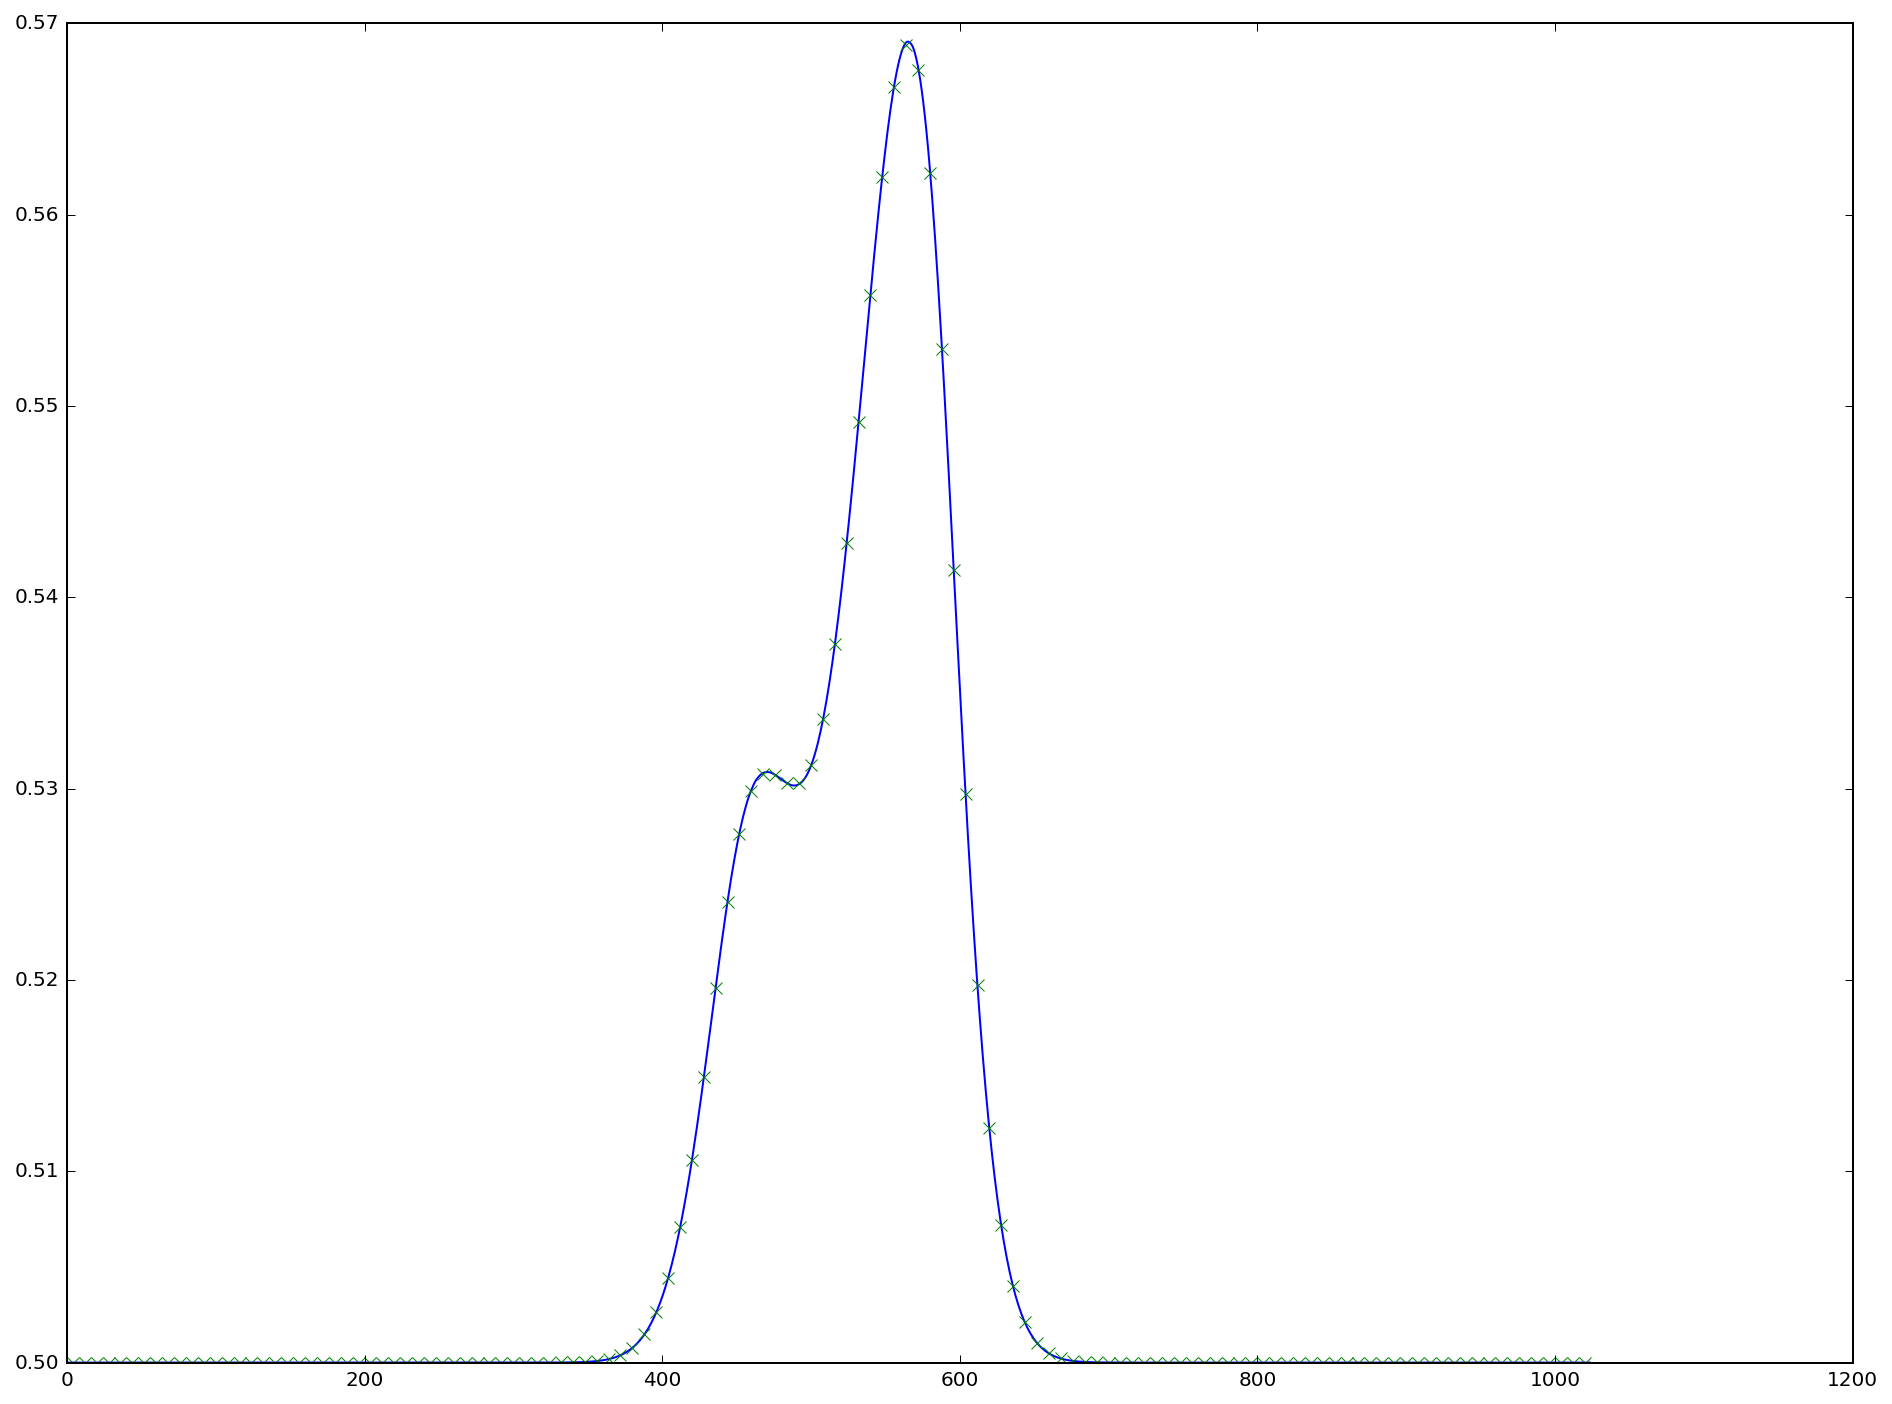

In [7]:
h, hu, hv = run_benchmark(KP07.KP07, 1024, 2)

x = np.linspace(0.5, 1023.5, 1024)

rh = downsample(h, 8)
rx = downsample(x, 8)

print h.shape
print rh.shape
print x.shape
print rx.shape

plt.figure()
plt.plot(x, h)
plt.plot(rx, rh, 'x')
plt.show()

In [8]:
domain_sizes = [128, 256, 512, 1024, 2048, 4096]
simulators = [LxF.LxF, FORCE.FORCE, HLL.HLL, HLL2.HLL2, WAF.WAF, KP07.KP07, KP07_dimsplit.KP07_dimsplit]
simulator_ghost_cells = [1, 1, 1, 2, 2, 2, 2]
simulator_names = ['LxF', 'FORCE', 'HLL', 'HLL2', 'WAF', 'KP07', 'KP07 dimsplit']
simulator_reference = [KP07.KP07, KP07.KP07, KP07.KP07, HLL2.HLL2, WAF.WAF, KP07.KP07, KP07_dimsplit.KP07_dimsplit]
simulator_courant_numbers = [0.95, 0.95, None, None, None, None, None]
const_dt = 0.45 * (100.0/float(max(domain_sizes))) / (1.0 + np.sqrt(9.81*0.6))
simulator_dt = [None, None, const_dt, const_dt, const_dt, const_dt, 0.5*const_dt]

LxF


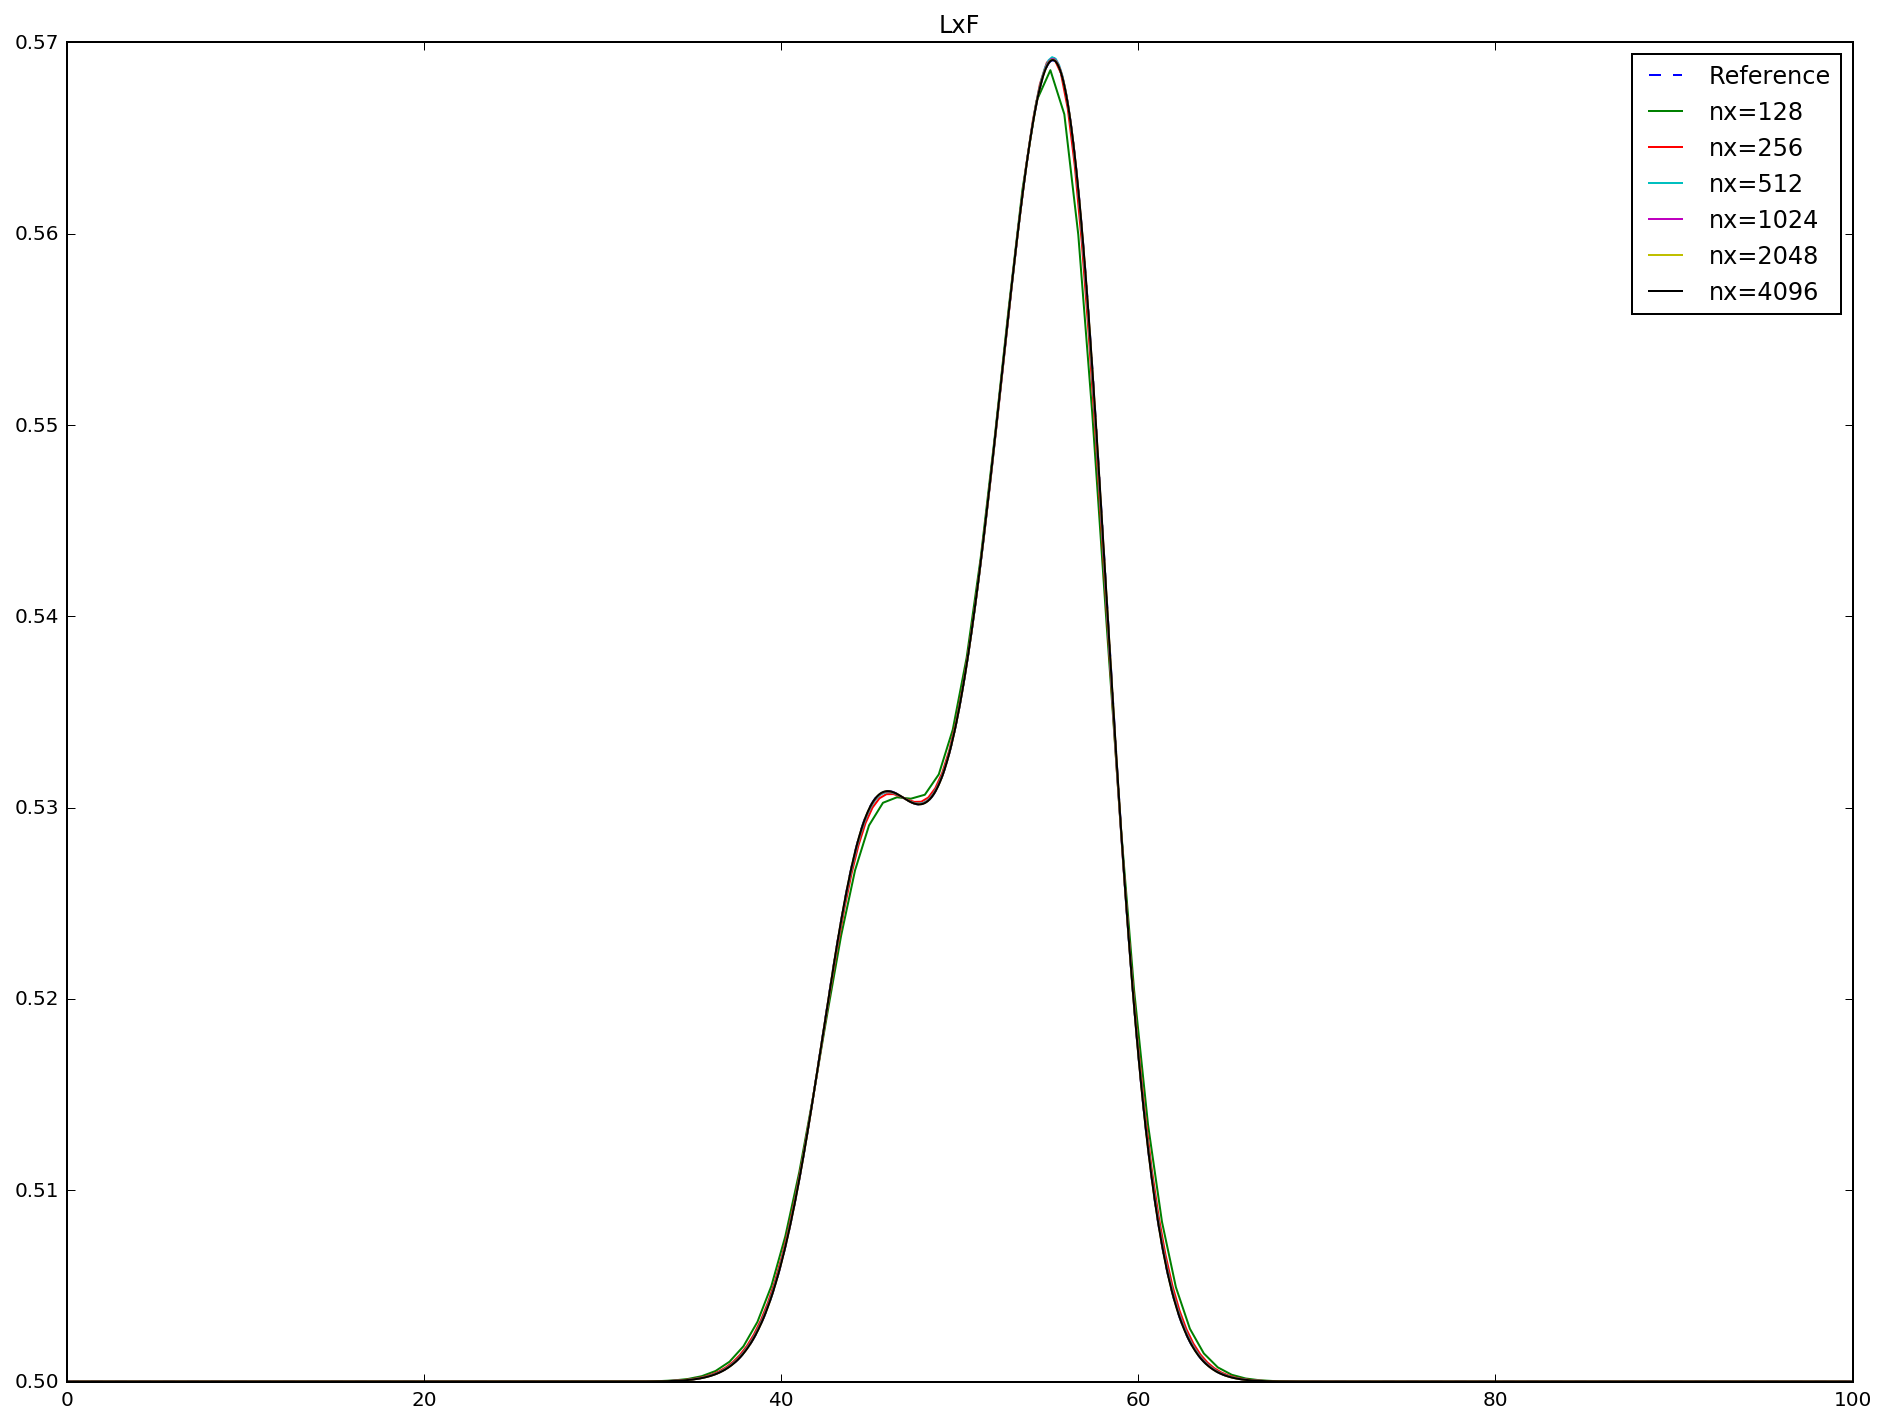

FORCE


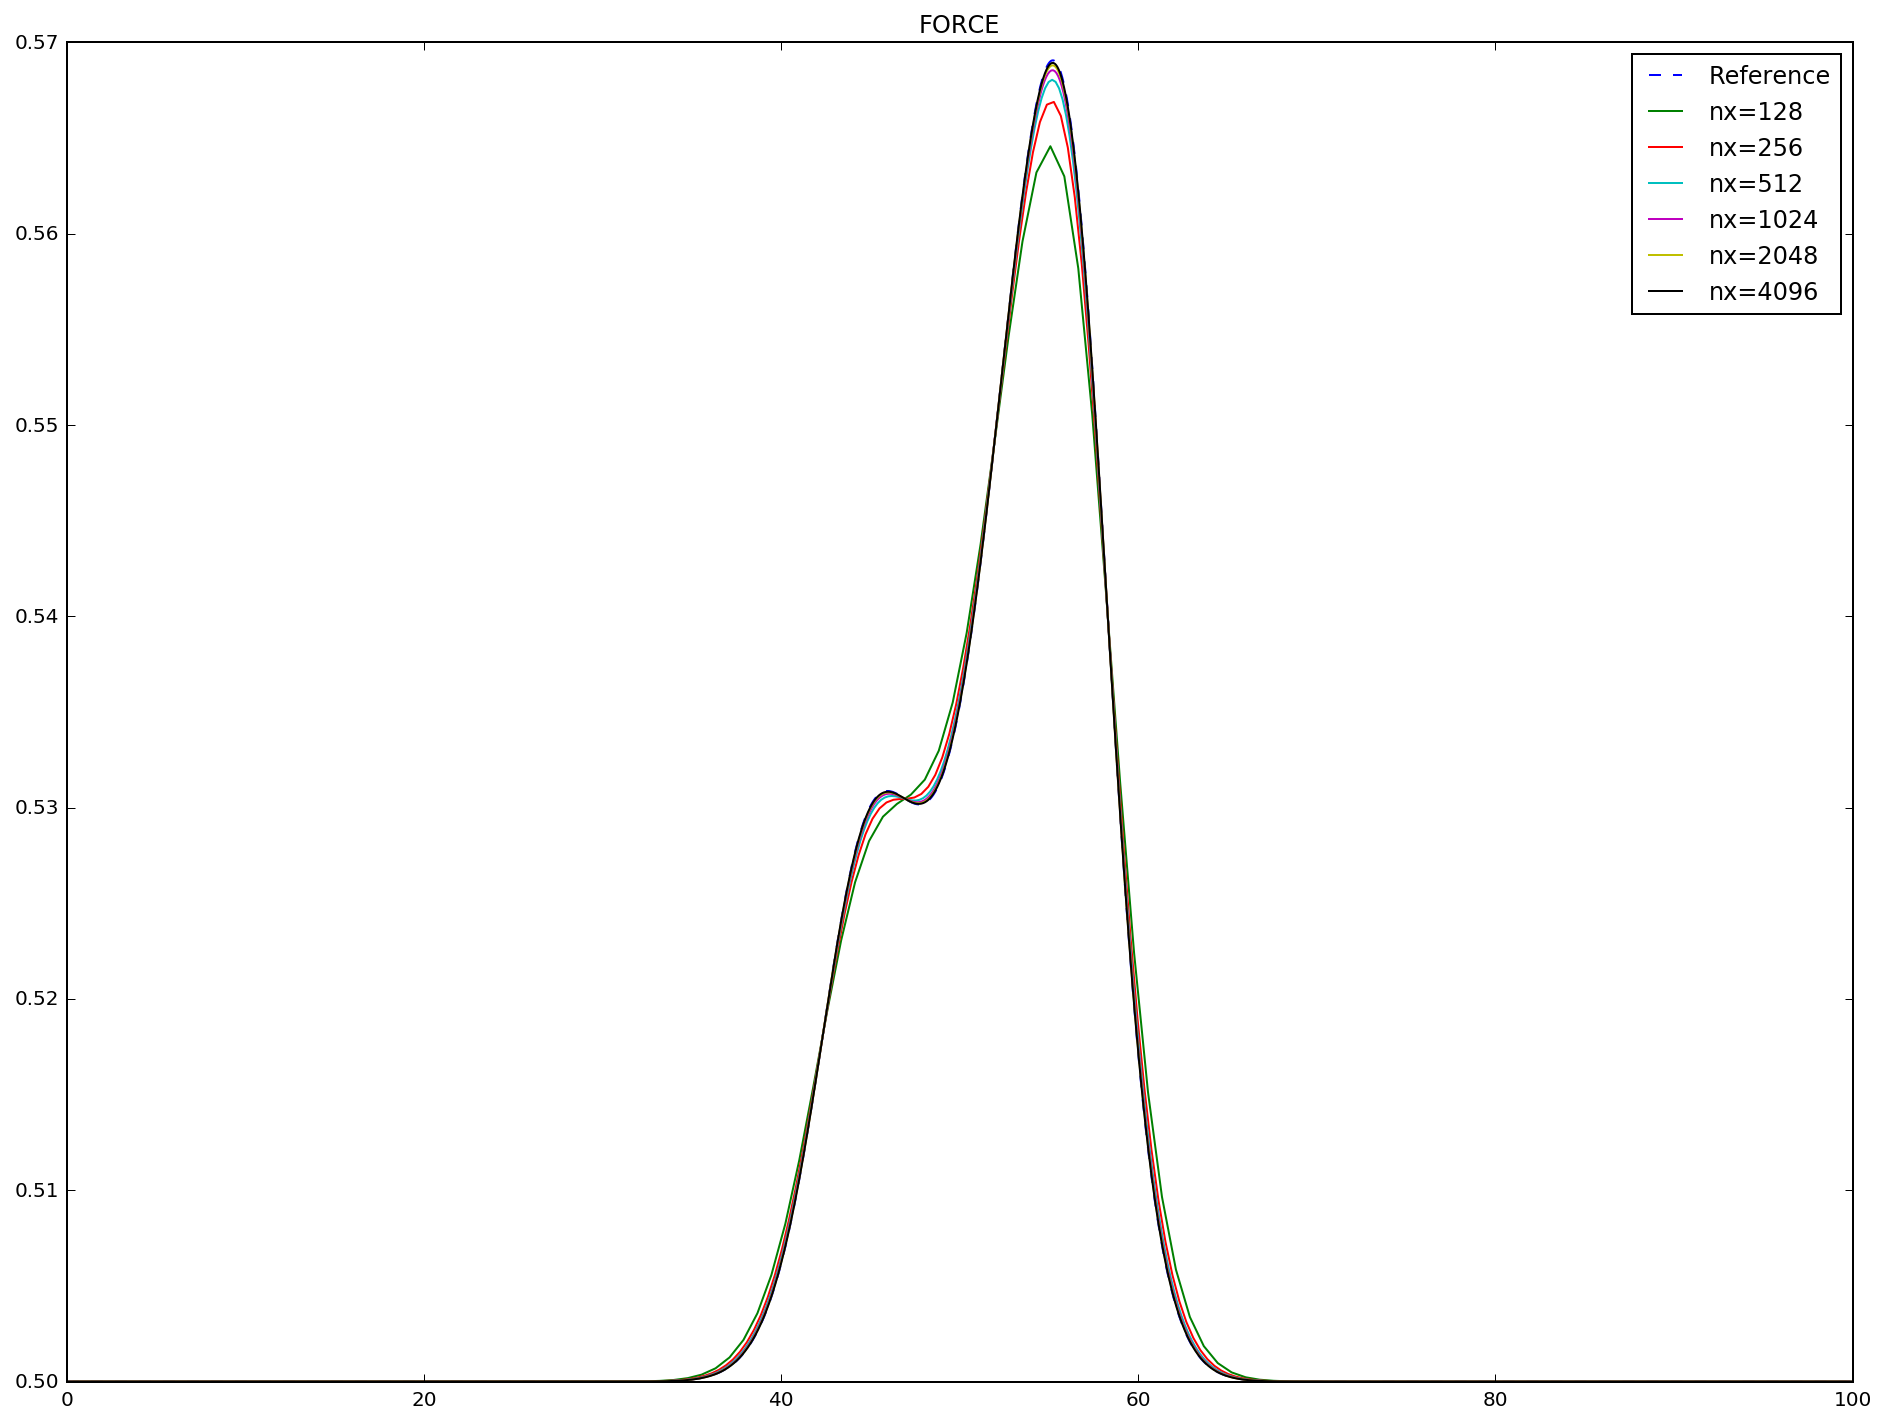

HLL


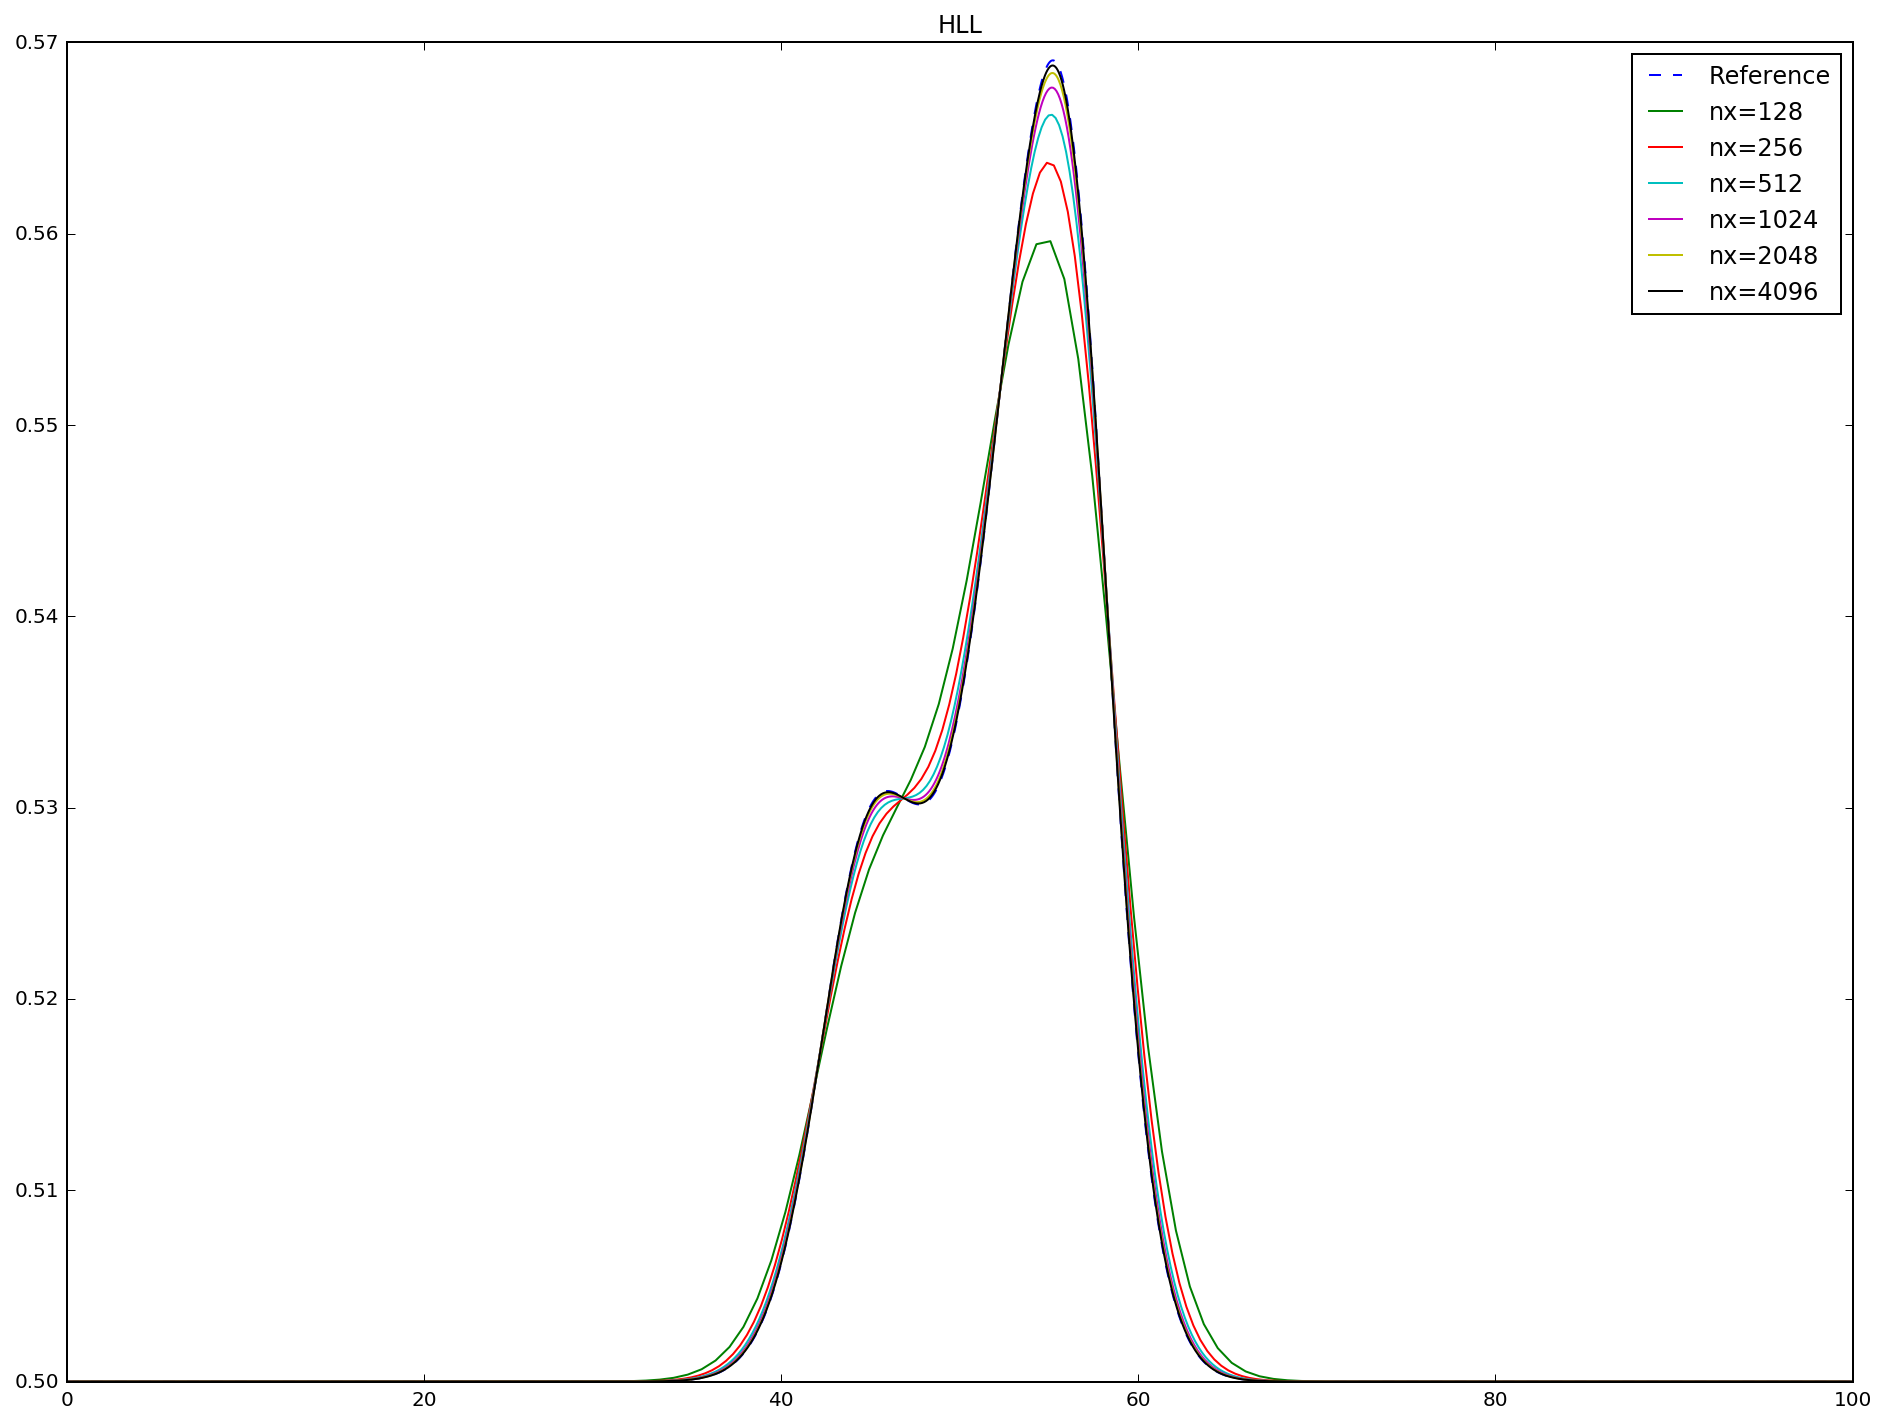

HLL2


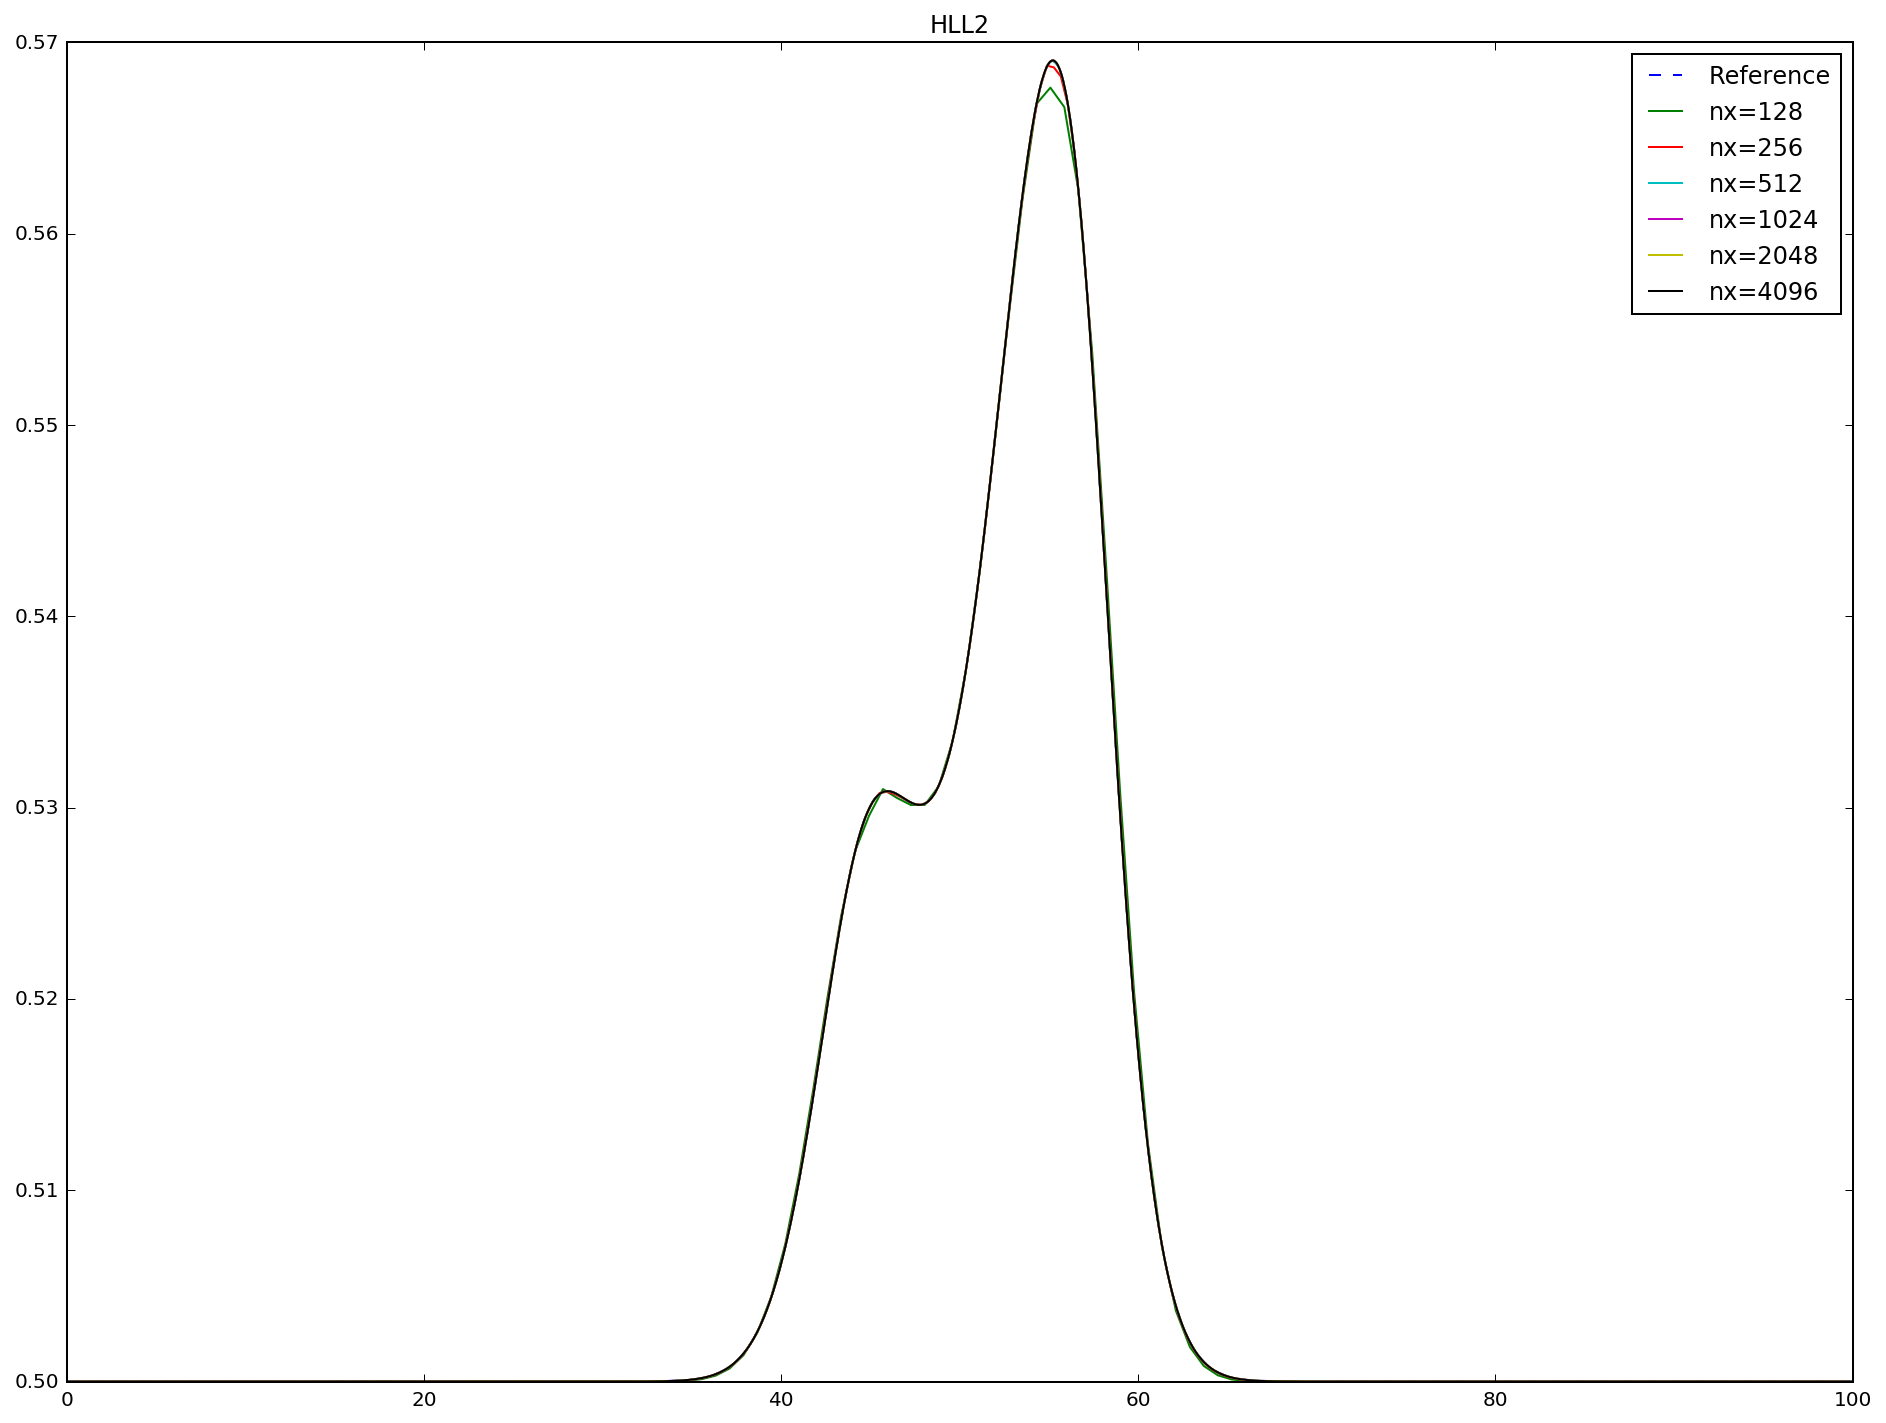

WAF


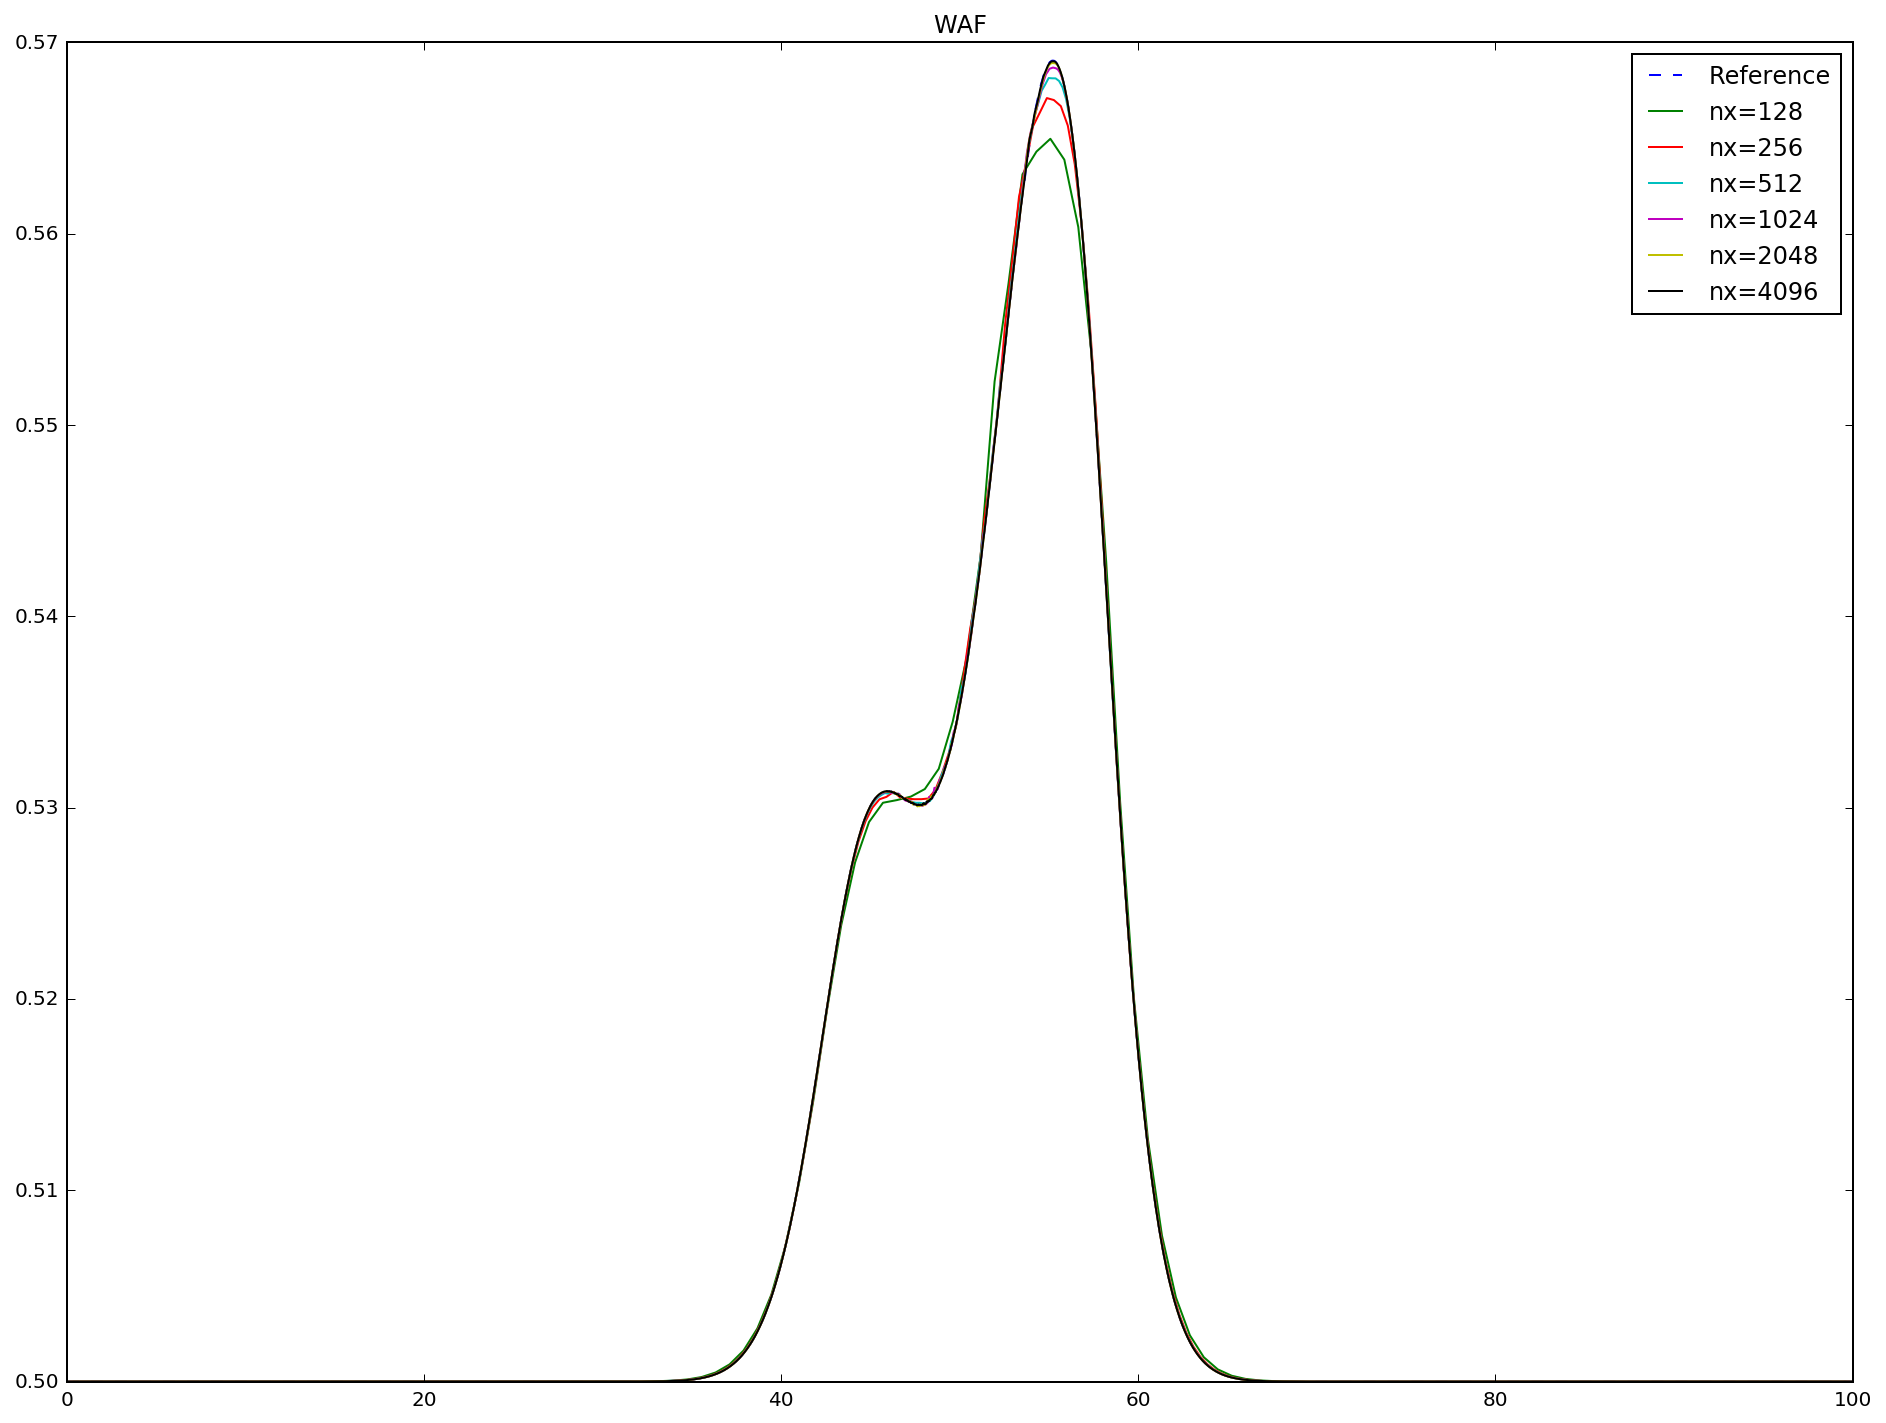

KP07


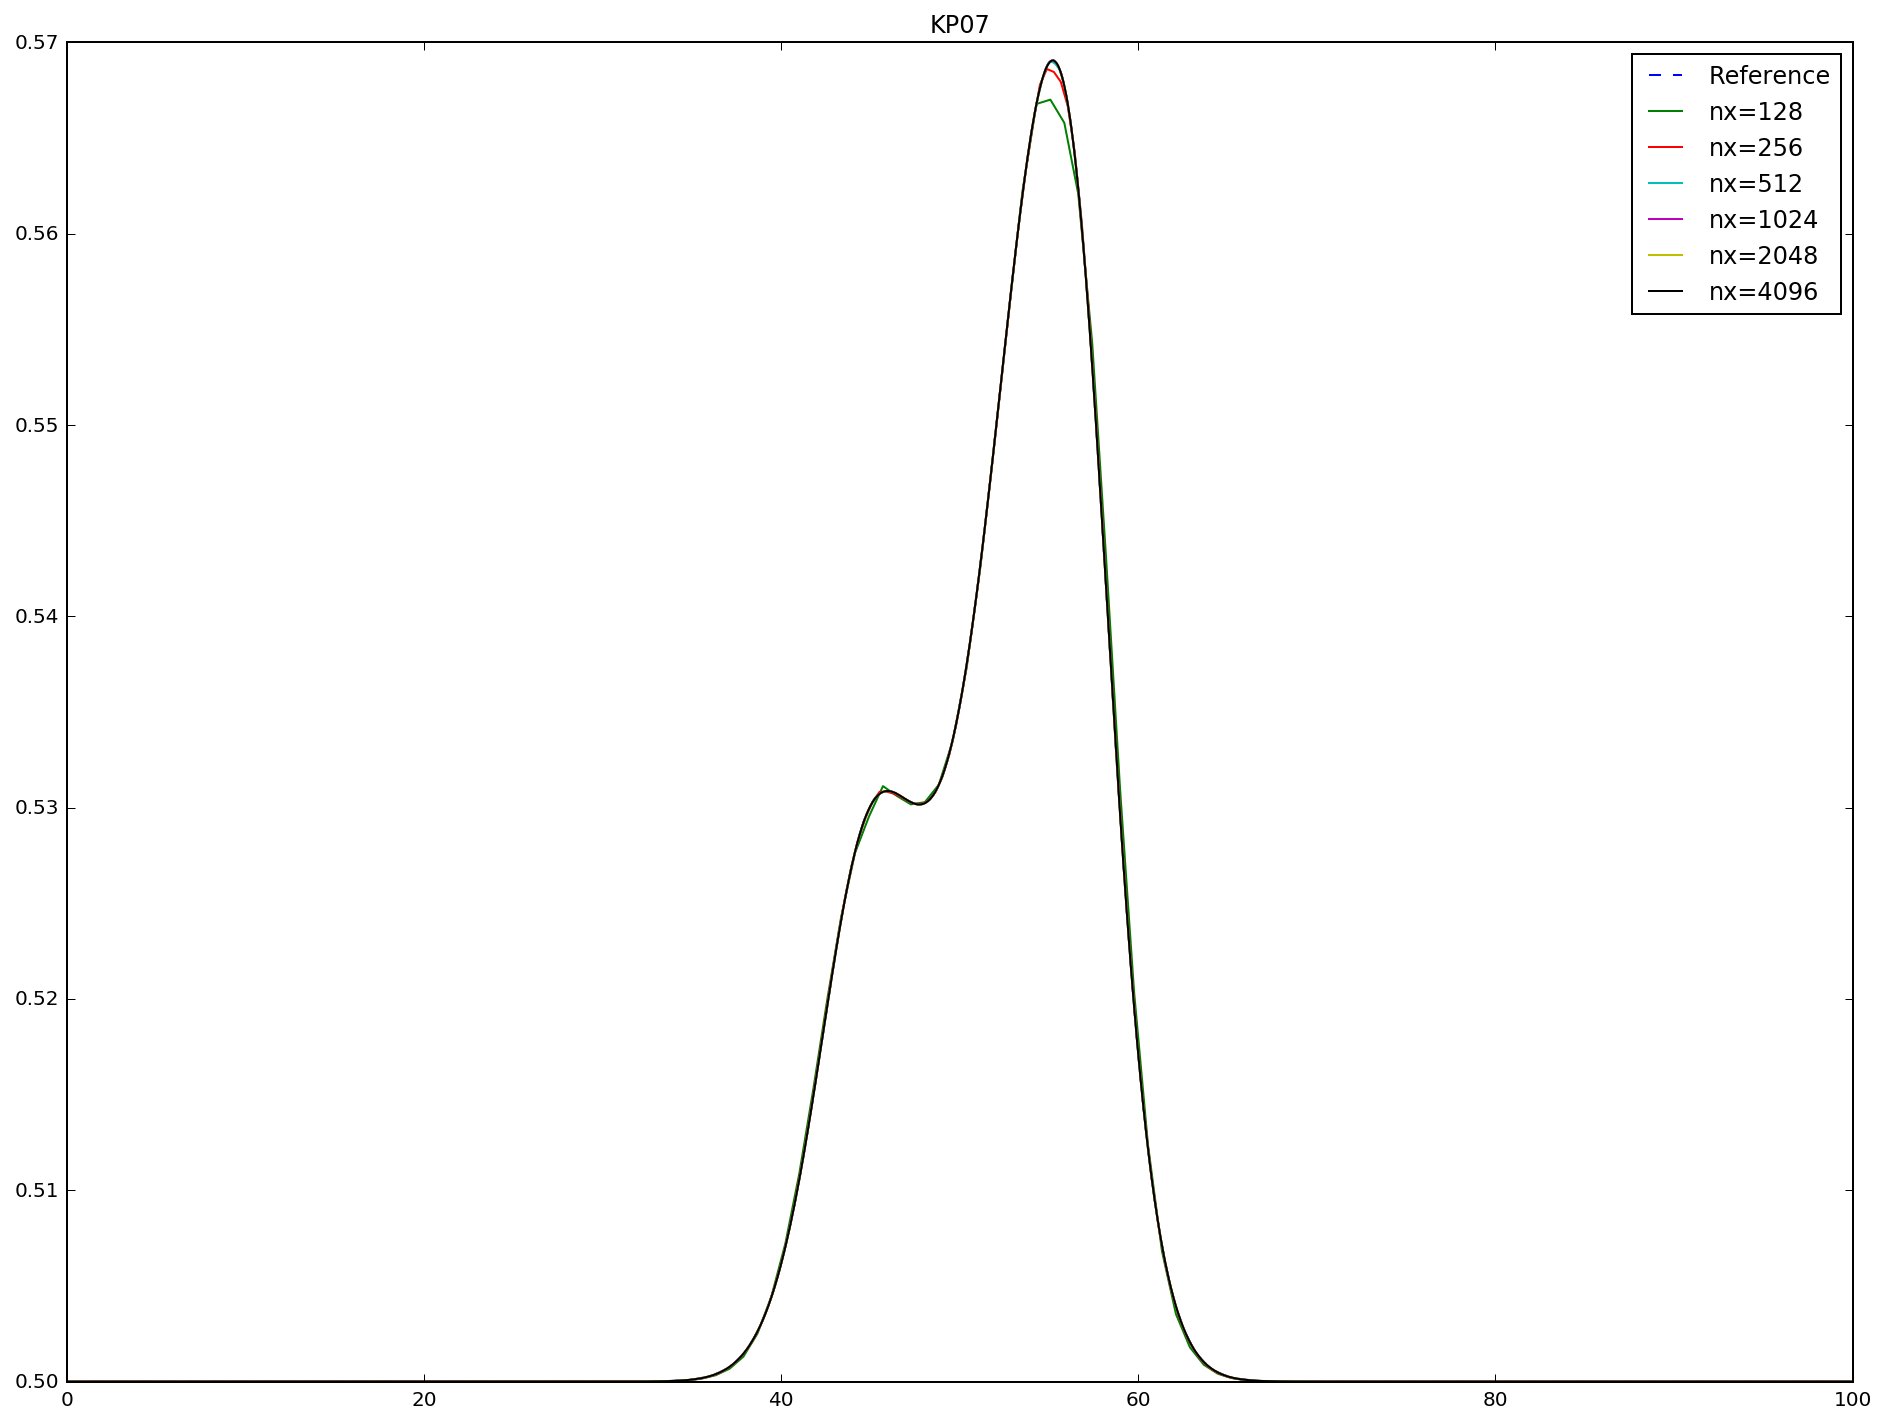

KP07 dimsplit


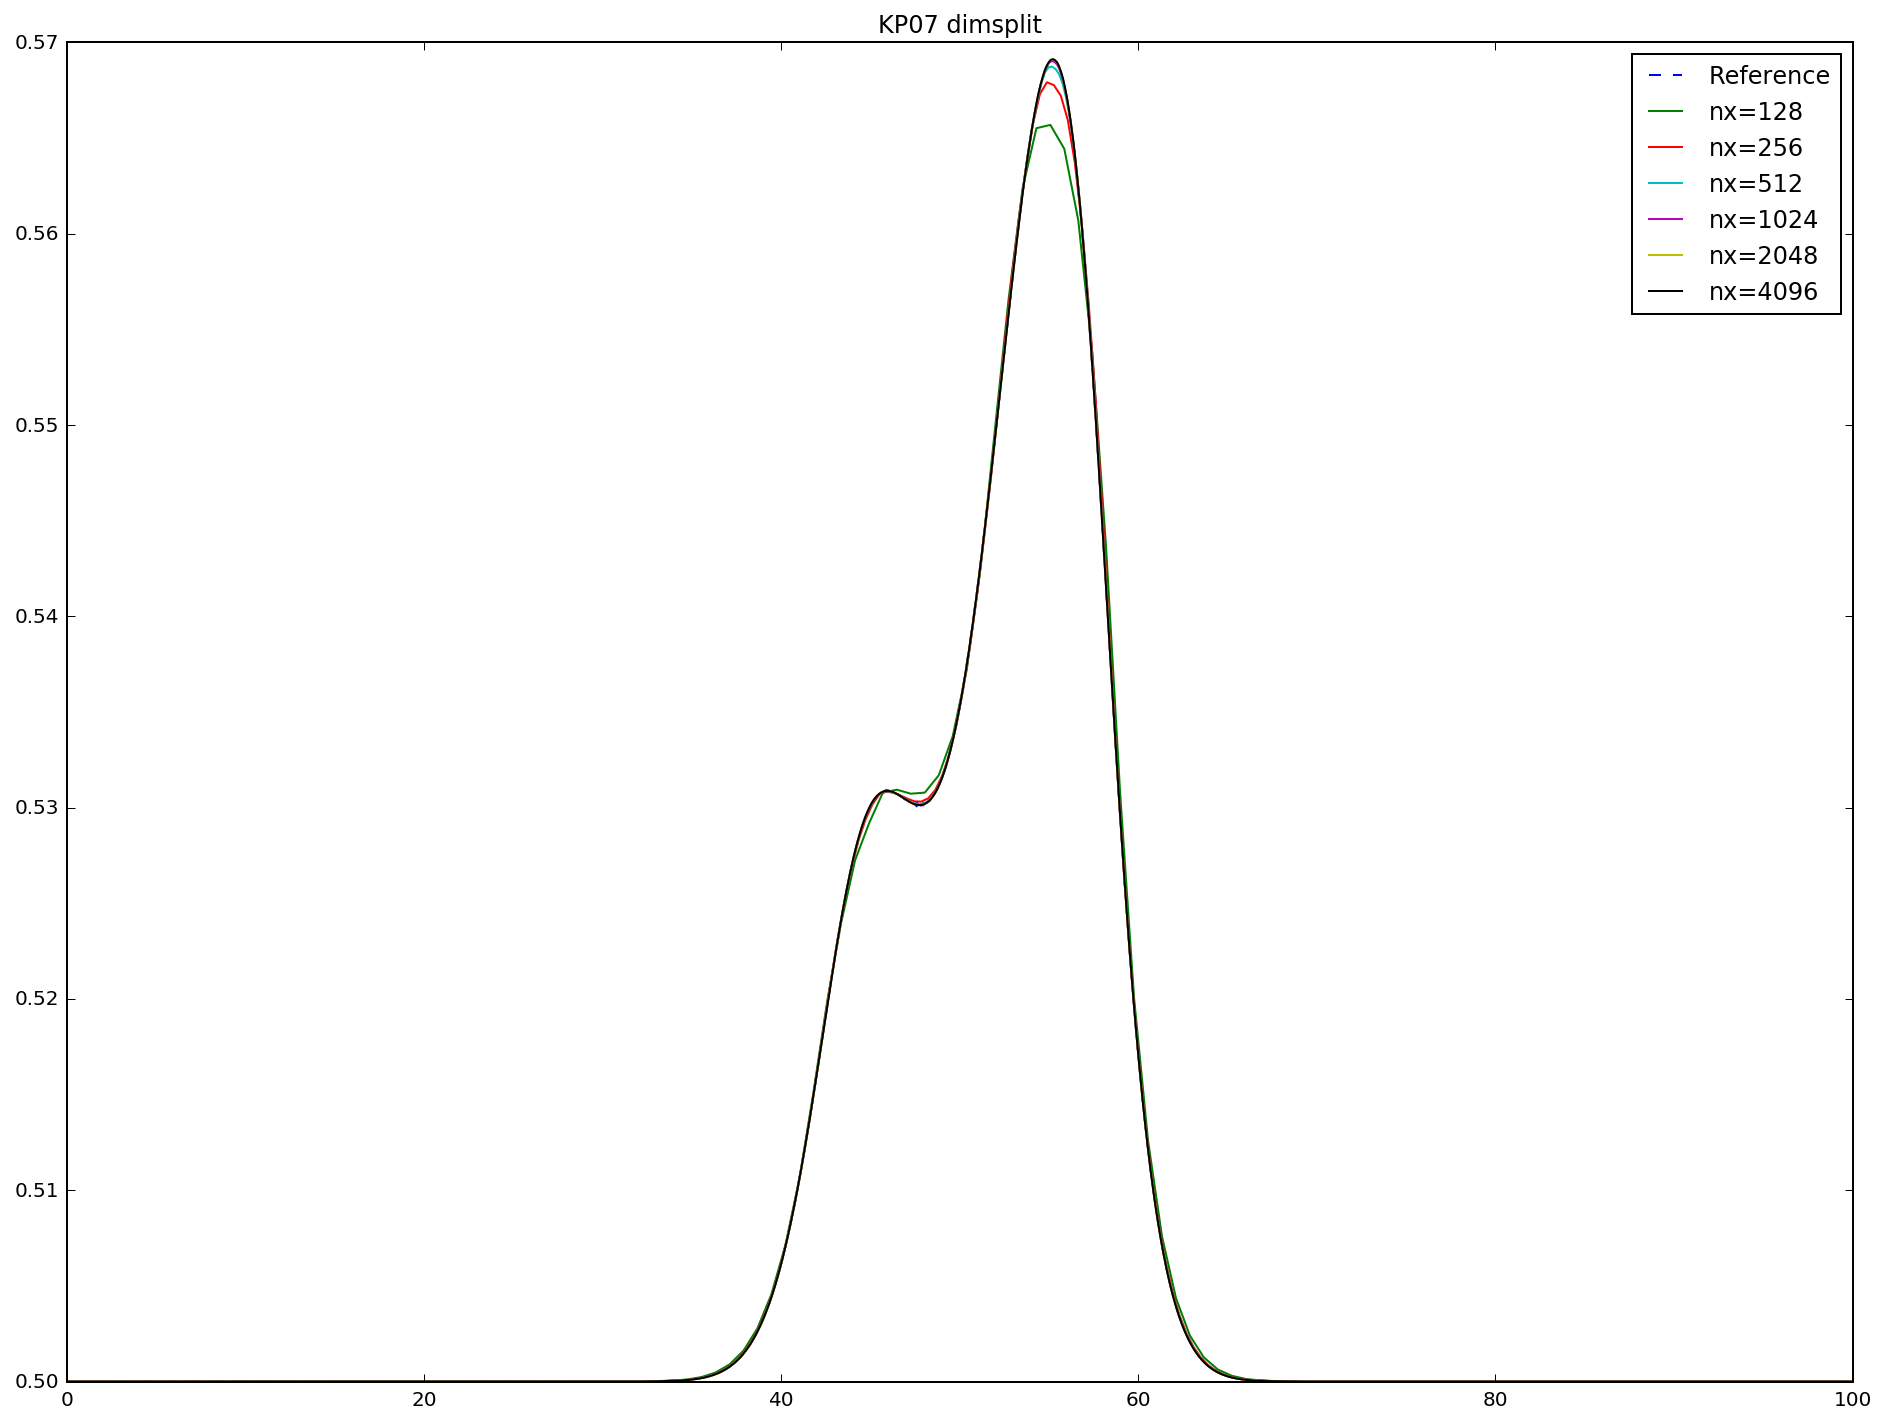

In [9]:
conservation = np.zeros((len(simulators), len(domain_sizes)))
error = np.zeros((len(simulators), len(domain_sizes)))

for i in range(len(simulators)):
    print simulator_names[i]
    reference_nx = max(domain_sizes)*4
    #h_ref, _, _ = run_benchmark(simulators[i], reference_nx, simulator_ghost_cells[i])
    h_ref, _, _ = run_benchmark(simulator_reference[i], reference_nx, 2)
    
    plt.figure()
    x = np.linspace(0.5, reference_nx-0.5, reference_nx)*100.0/float(reference_nx)
    plt.plot(x, h_ref, '--', label='Reference')
    
    h_ref = downsample(h_ref, reference_nx/min(domain_sizes))
    
    gc.collect()
    
    for j, nx in enumerate(domain_sizes):
        x = np.linspace(0.5, nx-0.5, nx)*100.0/float(nx)
        h, _, _ = run_benchmark(simulators[i], \
                                nx, \
                                simulator_ghost_cells[i], \
                                courant_number=simulator_courant_numbers[i], \
                                dt_in=simulator_dt[i])
        gc.collect()
        
        plt.plot(x, h, label='nx=' + str(nx))
        
        h = downsample(h, nx/min(domain_sizes))
        error[i, j] = np.linalg.norm(np.abs(h_ref - h), ord=1)
        conservation[i, j] = (np.sum(h_ref) - np.sum(h))
    plt.title(str(simulator_names[i]))
    plt.legend()
    plt.show()

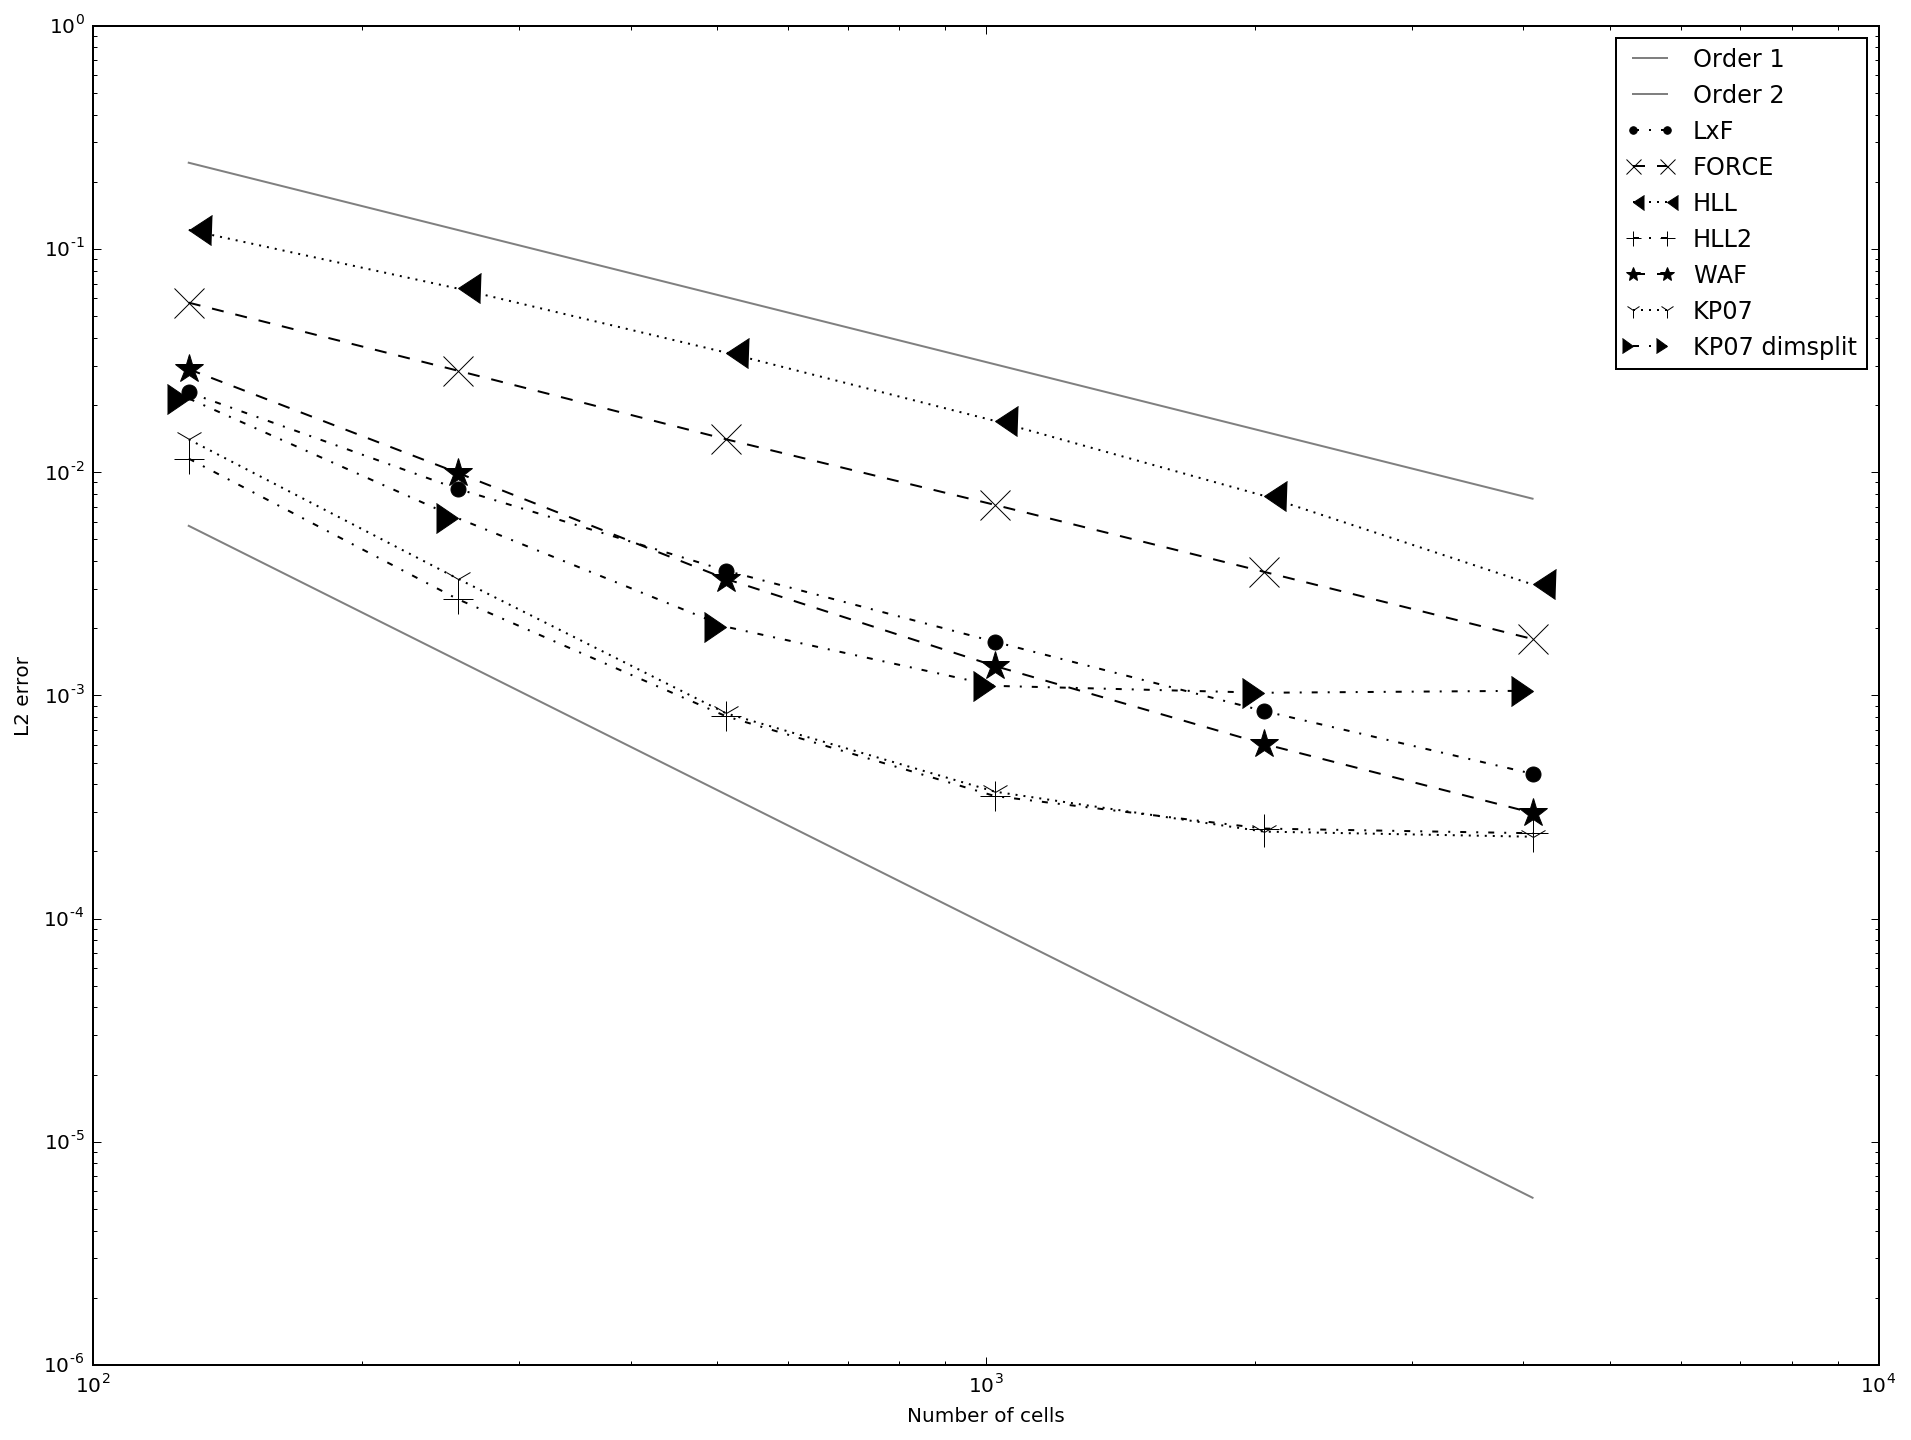

In [10]:
fig = plt.figure()
setBwStyles(fig.gca())

x = np.linspace(domain_sizes[0], domain_sizes[-1], 100);

#scaling = np.min(error[:,0]) * domain_sizes[0]**0.5 * 0.5
#plt.loglog(x, scaling/(np.sqrt(x)), '-', color='gray', label='Order 0.5')

scaling = np.max(error[:,0]) * domain_sizes[0] * 2
plt.loglog(x, scaling/x, '-', color='gray', label='Order 1')

scaling = np.min(error[:,0]) * domain_sizes[0]**2 * 0.5
plt.loglog(x, scaling/(x*x), '-', color='gray', label='Order 2')

for i in range(len(simulators)):
    plt.loglog(domain_sizes, error[i,:], label=simulator_names[i], markersize=15)
    
plt.xlabel('Number of cells')
plt.ylabel('L2 error')
plt.legend(markerscale=0.5)

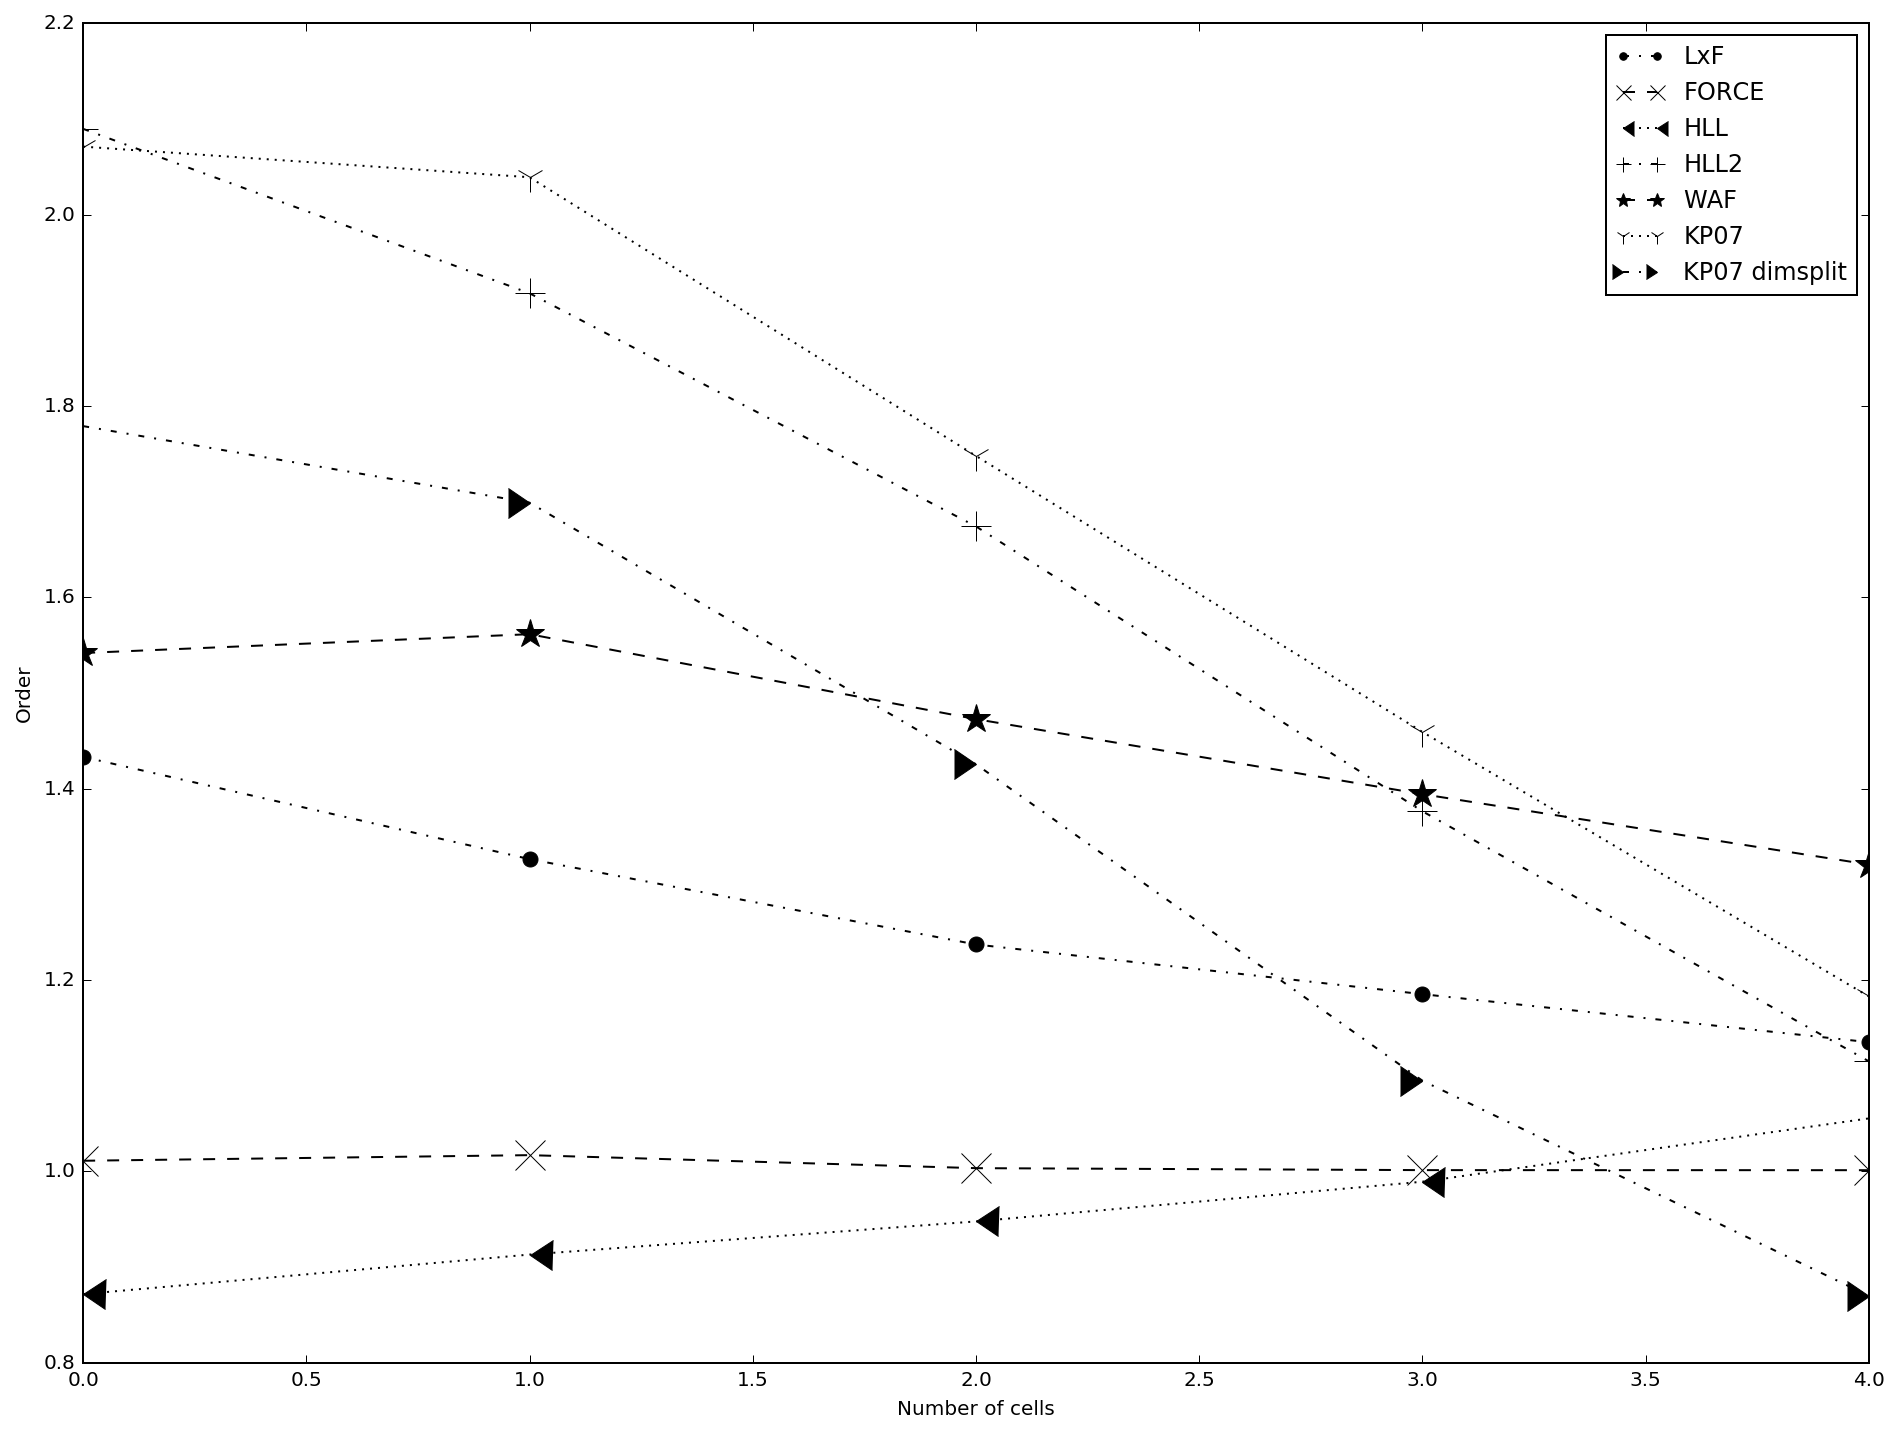

In [11]:
fig = plt.figure()
setBwStyles(fig.gca())

for i in range(len(simulators)):
    a = np.arange(1, len(domain_sizes))
    #order = np.log2(error[i, :-1] / error[i, 1:])
    order = np.log2(error[i, 0] / (error[i, 1:]) )/a
    plt.plot(order, label=simulator_names[i], markersize=15)
    
plt.xlabel('Number of cells')
plt.ylabel('Order')
plt.legend(markerscale=0.5)